## Ecommerce Trade Sales

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller

### Reading and Filtering data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


### Time series plot of Ecommerce trade sales

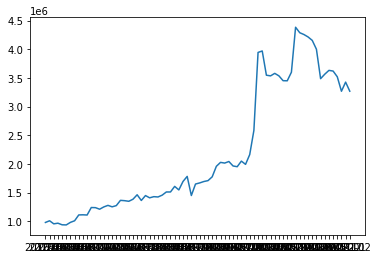

In [5]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index=retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [15]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [29]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-01,977198,0.000000
2016-02,1006610,0.030098


In [17]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()

In [28]:
retailEcommercesales_ts['Growth_rate'][0] = '0'

C:\Users\hp\AppData\Local\Temp\ipykernel_9496\1695327831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retailEcommercesales_ts['Growth_rate'][0] = '0'


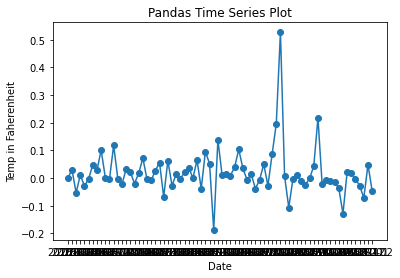

<Figure size 21600x2160 with 0 Axes>

In [82]:
# Plot
plt.plot(retailEcommercesales_ts['Growth_rate'], marker='o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("Temp in Faherenheit")
plt.title("Pandas Time Series Plot")



# Display
plt.show()

**KPSS Test**

In [73]:
def kpss_test(timeseries):
    print("Result from the ADF Stationarity Test: ")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        print("    The series is stationary with 5% level of significant")
    else:
        print("    The series is not stationary with 5% level of significant")

In [74]:
kpss_test(retailEcommercesales_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The series is stationary


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Interpretation:**

The test indicates that the series is stationary as p-value is greater than 5% level of significance implying we fail to reject the null hypothesis.

**ADF Test**

In [34]:
adfuller(retailEcommercesales_ts['Growth_rate'], autolag="AIC")

In [71]:
def adf_test(timeseries):
    print("Result from the ADF Stationarity Test: ")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    
    if dftest[1] < 0.05 :
        print("    The series is Stationary with 5% level of significant")
    else:
        print("    The series is Non-Stationary with 5% level of significant")

In [72]:
adf_test(retailEcommercesales_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The Series is Stationary


**Interpretation:**

The test indicates that the series is stationary as p-value is smaller than 5% level of significance implying we reject the null hypothesis.

### Keywords extraction using PyTrend

In [83]:
pytrends = TrendReq(hl='en-us', backoff_factor=0.1)

def ecommerce_trend(keywords=[''],category='340'):
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat=category
    timeframe = '2004-01-01 2022-05-11'
    geo='CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop='')
    data = pytrends.interest_over_time()
    #queries = pytrends.related_queries()
    #topics = pytrends.related_topics()
    
    return data #, queries, topics

**category_ts**

In [85]:
category_ts = ecommerce_trend(keywords=[''],category='340')

**Dictionary of keywords**

In [7]:
data, queries, topics = ecommerce_trend(keywords=[''],category='340')  #function calling

keyword_query_frame= dict()  #Dictionary for queries
keyword_topic_frame= dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].values.tolist() 
keyword_top_query = queries['']['top']['query'].values.tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].values.tolist() 
keyword_top_topics = topics['']['top']['topic_title'].values.tolist()

In [8]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [9]:
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'PayPal',
  'PayPal',
  'Money',
  'Canada',
  'Shopify',
  'Shopify',
  'Number',
  'Western Union',
  'Bank',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Shopify',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

In [10]:
#set formatted

#keyword_frame = set()
#keyword_frame1 = data['']['rising']['topic_title']
#keyword_frame2 = data['']['top']['topic_title']
#keyword_frame.update(keyword_frame1)
#keyword_frame.update(keyword_frame2)